In [70]:
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from tqdm import tqdm
from sklearn.svm import SVC

## Gen data

In [71]:
SEED = 0
np.random.seed(SEED)

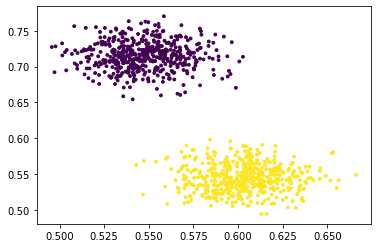

In [72]:
CLASSES = 2
NUM_OF_EACH_CLASS = 500
DIM = 2
STD = .02

centers = np.random.rand(CLASSES, DIM)
X = np.concatenate(
    [np.random.normal(center, STD, (NUM_OF_EACH_CLASS, DIM)) for center in centers], axis=0
)
y = np.concatenate(
    [np.array([i for _ in range(NUM_OF_EACH_CLASS)]) for i in range(CLASSES)], axis=0
)

plt.scatter(X[:, 0], X[:, 1], s=8, c=y)

## Cal manifold kernel density estimation

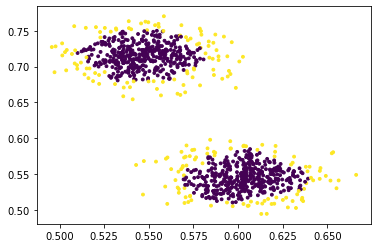

In [73]:
BANDWIDTH = 0.005

kde = KernelDensity(kernel='gaussian', bandwidth=BANDWIDTH)
kde_value = kde.fit(X).score_samples(X)
kde_argsort = np.argsort(kde_value)

is_tube = np.zeros(X.shape[0])
is_tube[kde_argsort[:int(CLASSES * NUM_OF_EACH_CLASS * 0.2)]] = 1
plt.scatter(X[:, 0], X[:, 1], s=8, c=is_tube)

## Experiment to Confirm Theorem

In [74]:
left_hand = np.empty(X.shape[0])
d_hat_h_o = np.empty(X.shape[0])
d_hat_h_t = np.empty(X.shape[0])
right_hand = np.empty(X.shape[0])

C_VALUE = 1
NUM_RANDOM = 50
VC_DIM = 100

clf_o = SVC(C=C_VALUE, kernel='rbf').fit(X, y)
clf_t = SVC(C=C_VALUE, kernel='rbf')
clfs_random = [
    SVC(C=C_VALUE, kernel='rbf').fit(np.random.rand(CLASSES, DIM), np.array([i for i in range(CLASSES)])) for _ in range(NUM_RANDOM)
]
start = -1
for i in tqdm(range(int(X.shape[0]))):
    # when there is no enough categories of classes
    if len(set(y[kde_argsort[:i + 1]])) < CLASSES:
        left_hand[i] = -2
        d_hat_h_t[i] = -1
        d_hat_h_o[i] = -1
        right_hand[i] = -2
        continue
    if start == -1:
        start = i
    # calculation - left hand
    y_hat_t = clf_t.fit(X[kde_argsort[:i + 1]], y[kde_argsort[:i + 1]]).predict(X)
    y_hat_o = clf_o.predict(X)
    left_hand[i] = (1 - np.mean(y_hat_t == y)) - (1 - np.mean(y_hat_o == y))
    # calculation - right hand
    d_hat_h_t[i] = -1
    d_hat_h_o[i] = -1
    for clf_random in clfs_random:
        y_hat_random = clf_random.predict(X)
        d_hat_h_t[i] = max(d_hat_h_t[i], np.abs((1 - np.mean(y_hat_random == y_hat_t)) - 
            (1 - np.mean(y_hat_random[kde_argsort[:i + 1]] == y_hat_t[kde_argsort[:i + 1]]))))
        d_hat_h_o[i] = max(d_hat_h_o[i], np.abs((1 - np.mean(y_hat_random == y_hat_o)) - 
            (1 - np.mean(y_hat_random[kde_argsort[:i + 1]] == y_hat_o[kde_argsort[:i + 1]]))))

100%|██████████| 1000/1000 [00:25<00:00, 39.01it/s]


## Draw

Text(0.5, 0, 'Proportion of tube points')

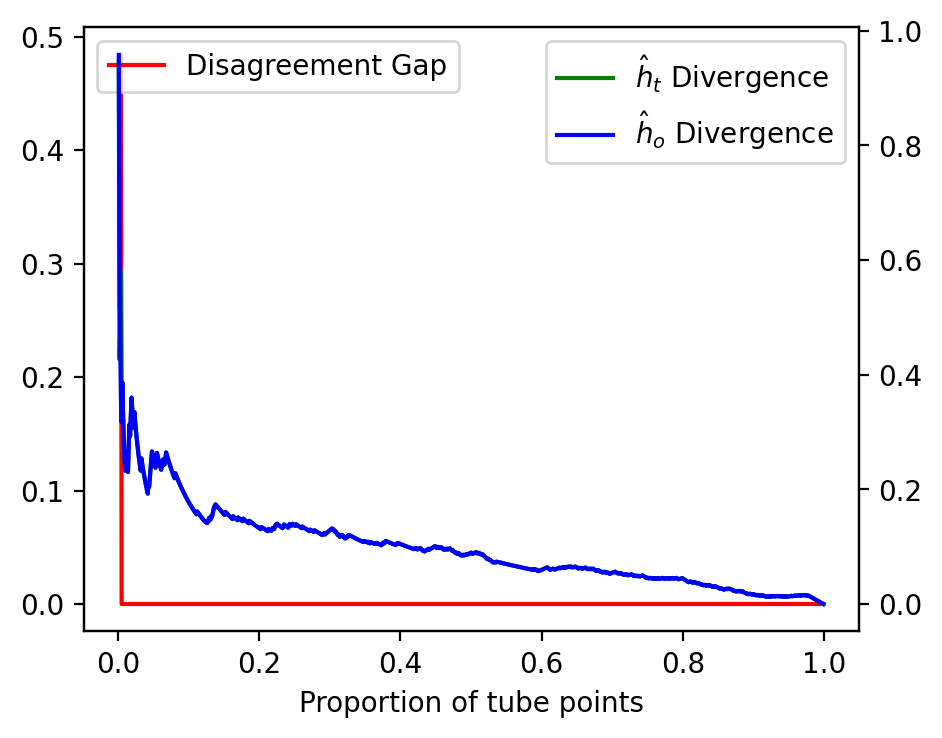

In [75]:
PROPORTION = 1

fig = plt.figure(dpi=200, figsize=(5, 4))
ax = fig.add_subplot(111)
ax.plot(np.arange(start + 1, int(X.shape[0] * PROPORTION)) / X.shape[0], left_hand[start + 1:int(X.shape[0] * PROPORTION)], '-r', label='Disagreement Gap')
ax2 = ax.twinx()
ax2.plot(np.arange(start, int(X.shape[0] * PROPORTION)) / X.shape[0], d_hat_h_t[start:int(X.shape[0] * PROPORTION)], '-g', label='$\hat h_t$ Divergence')
ax2.plot(np.arange(start, int(X.shape[0] * PROPORTION)) / X.shape[0], d_hat_h_o[start:int(X.shape[0] * PROPORTION)], '-b', label='$\hat h_o$ Divergence')
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
ax.set_xlabel('Proportion of tube points')